In [1]:
from jax import numpy as jnp
from jax import random as jr
from jax import vmap
import jax
from utils import reshape_emissions
from matplotlib import pyplot as plt
from lgssm_parameters import ParamsLGSSM, ParamsLGSSMInitial, ParamsLGSSMDynamics, ParamsLGSSMEmissions, ParameterProperties, sample_lgssm_params, initialize, log_prior
import tensorflow_probability.substrates.jax.distributions as tfd
from simulation_inference import sample_and_train
import blackjax


from dynamax.utils.plotting import plot_uncertainty_ellipses # type: ignore
from dynamax.linear_gaussian_ssm import LinearGaussianSSM # type: ignore
from dynamax.linear_gaussian_ssm import lgssm_smoother, lgssm_filter # type: ignore
from util.bijectors import RealToPSDBijector # type: ignore
from dynamax.parameters import to_unconstrained, from_unconstrained, log_det_jac_constrain # type: ignore

## Define SSM and priors. Sample ***true*** data.

In [2]:
num_timesteps = 1000
state_dim = 1
emission_dim = 1
input_dim = 0
delta = 1.0

# Default parameters
if state_dim ==4:
    initial_mean = jnp.array([8.0, 10.0, 1.0, 0.0])
    initial_covariance = jnp.eye(state_dim) * 0.1
    dynamics_weights  = 0.9 * jnp.array([[1, 0, delta, 0],
                                [0, 1, 0, delta],
                                [0, 0, 1, 0],
                                [0, 0, 0, 1]])
else:
    initial_mean = jnp.zeros(state_dim)
    initial_covariance = jnp.eye(state_dim) * 0.1
    dynamics_weights  = 0.9 * jnp.eye(state_dim)

dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.001

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 1.0

# Initialize params and props
sample_constrained = False
m = emission_dim * (emission_dim + 1) // 2
dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=jnp.ones(m))
props, prior = initialize(state_dim, emission_dim, 
                            sample_constrained=sample_constrained,
                            initial_mean=initial_mean,
                            initial_covariance=initial_covariance,
                            dynamics_weights=dynamics_weights,
                            dynamics_bias=dynamics_bias,
                            dynamics_input_weights=dynamics_input_weights,
                            dynamics_covariance=dynamics_covariance,
                            emission_weights=emission_weights,
                            emission_bias=emission_bias,
                            emission_input_weights=emission_input_weights,
                            emission_covariance=dist)

### Sample ***true*** params and emissions

In [3]:
key, subkey = jr.split(jr.PRNGKey(315520))
true_lgssm = LinearGaussianSSM(state_dim, emission_dim)
true_params = sample_lgssm_params(prior, 1, key)[0]
if not sample_constrained : true_params = from_unconstrained(true_params, props)
true_states, true_emissions = true_lgssm.sample(true_params, subkey, num_timesteps)

## Learning the likelihood

In [ ]:
from density_models import MAF
from flax import nnx

lag = 10
din = emission_dim
n_params = 1
dcond = lag * emission_dim + n_params
reverse = True
random_order = False
batch_norm = False
dropout = False
nmades = 5
dhidden = 16
nhidden = 5
model = MAF(din, nmades, dhidden, nhidden, dcond, nnx.Rngs(0), random_order, reverse, batch_norm, dropout)


trained_model, sampled_params, list_dataset = sample_and_train(
    key = jr.PRNGKey(310),
    model = model,
    state_dim = state_dim,
    emission_dim = emission_dim,
    prev_dataset=[], 
    lag = lag,
    num_samples = 10,
    num_timesteps = 100, 
    proposal = prior,
    props = props,
    num_epochs = 2,
    learning_rate = 1 * 1e-4
)

Epoch 0, training loss: -45.087135314941406, validation loss: -55.511295318603516
Epoch 1, training loss: -45.12678146362305, validation loss: -55.551292419433594
10
Epoch 0, training loss: -44.22199249267578, validation loss: -65.48689270019531
Epoch 1, training loss: -44.29536437988281, validation loss: -65.56129455566406
20


### Plot the estimated log-likelihood

### Log-density (likelihood * prior)

In [18]:
lag = 10
cond_emissions = reshape_emissions(true_emissions, lag)

def logdensity_fn(cond_params):
    tile_cond_params = jnp.tile(cond_params, (num_timesteps, 1))
    lp = -trained_model.loss_fn(jnp.concatenate([tile_cond_params, cond_emissions, true_emissions], axis=1))
    lp += log_prior(cond_params, prior)
    return lp

def loglik(cond_params):
    tile_cond_params = jnp.tile(cond_params, (num_timesteps, 1))
    ll = -trained_model.loss_fn(jnp.concatenate([cond_params, cond_emissions, true_emissions], axis=1))
    return ll

def loglik_trainable(model, fixed_params, theta, cond_emissions):
        params = ParamsLGSSM(
        initial = fixed_params.initial,
        dynamics = ParamsLGSSMDynamics(
            weights = fixed_params.dynamics.weights,
            bias = fixed_params.dynamics.bias,
            input_weights = fixed_params.dynamics.input_weights,
            cov = fixed_params.dynamics.cov),
        emissions = ParamsLGSSMEmissions(
            weights = fixed_params.emissions.weights,
            bias = fixed_params.emissions.bias,
            input_weights = fixed_params.emissions.input_weights,
            cov = jnp.array([theta]))
        )
        return loglik(model, params, props, cond_emissions)

-0.23723724
-0.3993994


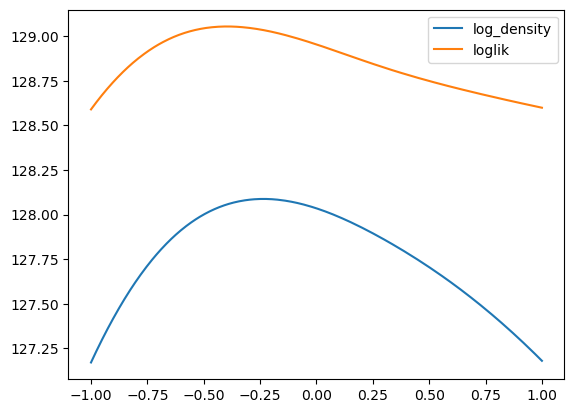

In [ ]:
unc_fixed_params = to_unconstrained(true_params, props) # This ensures that the model processes the unconstrained parameters
loglik1 = lambda theta: loglik_trainable(trained_model, unc_fixed_params, theta, cond_emissions)
thetas = jnp.linspace(-1.0, 1.0, 1000)
lls = vmap(loglik1)(thetas)

log_density_values = vmap(logdensity_fn)(thetas[:, None])
print(thetas[jnp.argmax(log_density_values)])
print(thetas[jnp.argmax(lls)])
plt.plot(thetas, log_density_values, label='log_density')
plt.plot(thetas, lls, label='loglik')
plt.legend()
plt.show()

## Posterior sampling

### SMC Sampler

In [ ]:
proposed_params = sample_lgssm_params(prior, 500, jr.PRNGKey(310))
param_value_list = []
log_weights = []
for params in proposed_params:
    param_value = params._flatten(props)
    param_value_list.append(param_value)
    cond_params = jnp.tile(param_value, (num_timesteps, 1))
    log_weights.append(loglik(cond_params)) 
log_weights = jnp.array(log_weights)
log_weights -= jnp.max(log_weights)
weights = jnp.exp(log_weights)
weights /= jnp.sum(weights)

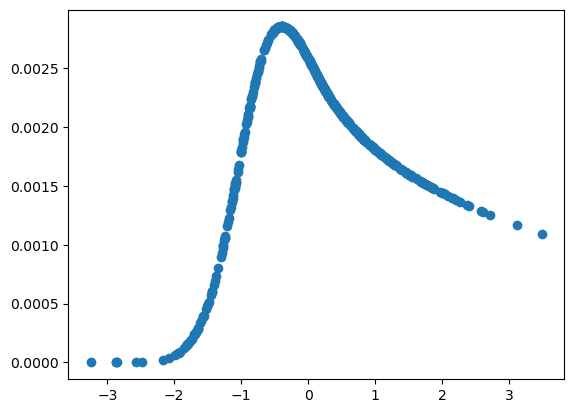

In [37]:
plt.scatter(jnp.array(param_value_list), weights)
plt.show()

### MCMC sampler

In [ ]:
from jax.flatten_util import ravel_pytree

inputs = None
initial_params = sample_lgssm_params(prior, 1, jr.PRNGKey(10))[0]
initial_cond_params = initial_params._flatten(props)


# p, unravel_fn = ravel_pytree(initial_unc_params)
inv_mass_matrix = jnp.eye(initial_cond_params.shape[0])
num_integration_steps = 30
step_size = 1e-4

hmc = blackjax.hmc(logdensity_fn, step_size, inv_mass_matrix, num_integration_steps)
initial_state = hmc.init(initial_cond_params)

nuts = blackjax.nuts(logdensity_fn, step_size, inv_mass_matrix)
initial_state = nuts.init(initial_cond_params)

hmc_kernel = jax.jit(hmc.step)
nuts_kernel = jax.jit(nuts.step)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [ ]:
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
rng_key, sample_key = jax.random.split(rng_key)
sampled_states = inference_loop(sample_key, nuts_kernel, initial_state, 1000)

In [ ]:
# last 25s (num epochs = 2)
plt.plot(sampled_states.logdensity)
plt.show()
plt.plot(sampled_states.position)
plt.show()

NameError: name 'plt' is not defined

Compute maximum likelihood estimates of the parameters

In [ ]:
unc_ML_params = ParamsLGSSM(
        initial = unc_fixed_params.initial,
        dynamics = ParamsLGSSMDynamics(
            weights = unc_fixed_params.dynamics.weights,
            bias = unc_fixed_params.dynamics.bias,
            input_weights = unc_fixed_params.dynamics.input_weights,
            cov = unc_fixed_params.dynamics.cov),
        emissions = ParamsLGSSMEmissions(
            weights = unc_fixed_params.emissions.weights,
            bias = unc_fixed_params.emissions.bias,
            input_weights = unc_fixed_params.emissions.input_weights,
            cov = jnp.array([thetas[jnp.argmax(log_density_values)]]))
)
ML_params = from_unconstrained(unc_ML_params, props)
print(ML_params.emissions.cov)
print(true_params.emissions.cov)

NameError: name 'ParamsLGSSM' is not defined

### Baseline: exact LGSSM log-likelihood

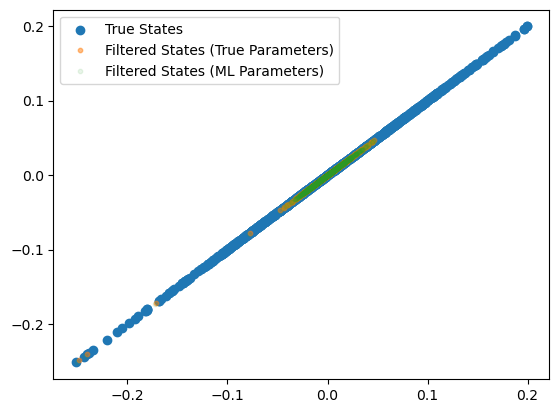

In [ ]:
posterior_filtered = true_lgssm.filter(true_params, true_emissions)
est_filtered = true_lgssm.filter(ML_params, true_emissions)
id1 = 0
id2 = 1
plt.scatter(true_states[:, id1], true_states[:, id2], label='True States')
plt.scatter(posterior_filtered.filtered_means[:, id1], posterior_filtered.filtered_means[:, id2], label = 'Filtered States (True Parameters)', alpha=0.5, s=10)
plt.scatter(est_filtered.filtered_means[:, id1], est_filtered.filtered_means[:, id2], label = 'Filtered States (ML Parameters)', alpha=0.1, s=10)
plt.legend()
plt.show()


### Compute true LG-SSM log-likelihood

In [7]:
def true_loglik(fixed_params, theta):
    params = ParamsLGSSM(
        initial = fixed_params.initial,
        dynamics = fixed_params.dynamics,
        emissions = ParamsLGSSMEmissions(
            weights = fixed_params.emissions.weights,
            bias = fixed_params.emissions.bias,
            input_weights = fixed_params.emissions.input_weights,
            cov = theta)
    )
    posterior_filtered = true_lgssm.filter(params, true_emissions)
    predicted_means = jnp.einsum('ij, tj -> ti', params.dynamics.weights, posterior_filtered.filtered_means)  + params.dynamics.bias
    predicted_covs = jnp.einsum('ij, tjl, kl  -> tik', params.dynamics.weights, posterior_filtered.filtered_covariances, params.dynamics.weights) + params.dynamics.cov
    y_means = jnp.einsum('ij, tj -> ti', params.emissions.weights, predicted_means) + params.emissions.bias
    y_covs = jnp.einsum('ij, tjl, kl  -> tik', params.emissions.weights, predicted_covs, params.emissions.weights) + params.emissions.cov
    true_loglik_t = lambda y, mean, cov: -0.5 * (y-mean).T @ jnp.linalg.solve(cov, y-mean) - 0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * emission_dim * jnp.log(2 * jnp.pi)
    trueloglik = vmap(true_loglik_t)(true_emissions, y_means, y_covs)
    return jnp.sum(trueloglik)

sigmas = props.emissions.cov.constrainer(thetas.reshape(-1, 1, 1)).flatten() #jnp.linspace(-2.0, 2.0, 1000)
new_lls = vmap(lambda theta: true_loglik(true_params, theta))(sigmas.reshape(-1, 1, 1))
plt.plot(sigmas, new_lls, label='True loglik')
plt.legend()
plt.show()
plt.plot(sigmas, lls, label='Estimated loglik')
plt.legend()
plt.show()

NameError: name 'thetas' is not defined

Comments:
- The model is able to recover the shape of the true log-likelihood.
- There is a significant difference in the value numerical values of the two plots. This might have to do with the fact that the loss function is not the exact log-likeliood. Moreover note that to recover the exact values I might need to use the log-determinant of the bijection used for the unconstrained parameters.